In [1]:
import numpy as np
import matplotlib.pyplot as plt

### Reference: Influence of hole shape on sound absorption of underwater anechoic layers
#### https://www.sciencedirect.com/science/article/abs/pii/S0022460X1830227X

### Start at eq(15) in the paper

In [2]:
## The effective density: (15)
## ai represents the inner radii of the pipe in the i th layer
def ith_effect_density(ai, cell_radius, rubber_den, air_den):
    return rubber_den*(1-(ai/cell_radius)**2) + air_den*(ai/cell_radius)**2


def ith_effect_speed(ai, cell_radius, rubber_speed, air_speed):
    rubber_speed = rubber_speed*(1-0.23j)
    return rubber_speed*(1-(ai/cell_radius)**2) + air_speed*(ai/cell_radius)**2


## The effective impedance of the i th segment: (16)
def ith_effect_impedance(ith_effect_density, omega, wave_number):
    return ith_effect_density*omega/wave_number


## The transfer matrix of the i th segment: (17)
def ith_tran_matrix(wave_number, li, ith_impedance):
    ti = np.zeros((2,2), dtype=complex)
    ti[0,0] = np.cos(wave_number*li)
    ti[0,1] = -1j*np.sin(wave_number*li)*ith_impedance
    ti[1,0] = -1j*np.sin(wave_number*li)/ith_impedance
    ti[1,1] = np.cos(wave_number*li)
    return ti

## The successive multi-plication of the transfer matrix of each segment: (18)
def total_tran_matrix(wave_number, lh, n, impedance):
    li = lh/n
    t0 = ith_tran_matrix(wave_number[0], li, impedance[0])
    tn=t0
    for i in range(1, n):
        tn = np.matmul(tn, ith_tran_matrix(wave_number[i], li, impedance[i]))
    return tn
    

## The impedance of the front interface Zf: (22)
def imped_front(tn):
    zf = np.absolute(tn[0,0]/tn[1,0])
#     zf = (tn[0,0]/tn[1,0])
    return zf


## The reflection coefficient of the anechoic layer: (23)
def reflection_coefficient(zf,zw):
    return (zf-zw)/(zf+zw)


## The sound absorption coefficient: (24)
def absorption_coefficient(reflection):
    return 1-np.absolute(reflection)**2

In [3]:
'''
All units are in SI
Density of rubber (kg/m3): 1100
Density of air (kg/m3): 1.21
Assume the pipe has a conical shape, as Fig. 7(a) in the paper:

pcone = 4 mm
qcone = 8 mm
lh = 40 mm
cell_radius = 15 mm

Assume 100 segments: num_segments = 100

Sound speed of water (m/s): 1483
'''

def effective_radius(pcone, qcone, lh, num_segments, shape='cone'):
    if shape == 'cone':
        alpha = (qcone-pcone)/lh
        beta = pcone
        lh_n = np.linspace(0, lh, num_segments)
        r_effective = alpha*lh_n + beta
    return r_effective


### Test above defined functions for a single frequency

In [4]:
frequency = 5000 #np.arange(0.1, 10000, 50)
omega = frequency * 2 * np.pi

## https://www.vibrationdata.com/tutorials_alt/speed.pdf
## sound speed = square_root(Young’s modulus / density)
## Young's modulus of rubber (GPa): 0.14
# Young_modulus = 0.14 * (10**9)


ai = effective_radius(4*0.001, 8*0.001, 40*0.001, 100, shape='cone')
effective_density = ith_effect_density(ai, 15*0.001, 1100, 1.21)

# effective_speed = np.sqrt(Young_modulus/effective_density)
effective_speed = ith_effect_speed(ai, 15*0.001, 60, 343)



wave_number = omega / effective_speed

effective_impedance = ith_effect_impedance(effective_density, omega, wave_number)
tn = total_tran_matrix(wave_number, 40*0.001, 100, effective_impedance)

## Acoustic impdedance of water: 1.48 MPa.s.m−1
## https://www.animations.physics.unsw.edu.au/jw/sound-impedance-intensity.htm

zw = 1.48*(10**6)
zf = imped_front(tn)
ref = reflection_coefficient(zf, zw)
alpha = absorption_coefficient(ref)

In [5]:
alpha

0.2054959428415296

### Integrate all calculations into one function

In [6]:
def absorption_frequency(frequency_array, pcone, qcone, lh, num_segments, 
                         cell_radius, rubber_den, air_den, rubber_speed, air_speed):
    
    frequency_array = np.asarray(frequency_array)
    absorption_list = []
    
    for frequency in frequency_array:
       
        omega = frequency * 2 * np.pi
        
        ## https://www.vibrationdata.com/tutorials_alt/speed.pdf
        ## sound speed = square_root(Young’s modulus / density)
        ## Young's modulus of rubber (GPa): 0.14
#         Young_modulus = Young_rubber

        ai = effective_radius(pcone, qcone, lh, num_segments, shape='cone')
        effective_density = ith_effect_density(ai, cell_radius, rubber_den, air_den)
        effective_speed = ith_effect_speed(ai, cell_radius, rubber_speed, air_speed)
        wave_number = omega / effective_speed
        
        effective_impedance = ith_effect_impedance(effective_density, omega, wave_number)
        tn = total_tran_matrix(wave_number, lh, num_segments, effective_impedance)

        ## Acoustic impdedance of water: 1.48 MPa.s.m−1
        ## https://www.animations.physics.unsw.edu.au/jw/sound-impedance-intensity.htm

        zw = 1.48*(10**6)
        zf = imped_front(tn)
        ref = reflection_coefficient(zf, zw)
        alpha = absorption_coefficient(ref)   
        absorption_list.append(alpha)
        
    return np.asarray(absorption_list)


In [7]:
frequency_array = np.arange(0.1, 10000, 50)
absorption_array = absorption_frequency(frequency_array, 4*0.001, 8*0.001, 40*0.001, 1000, 
                                        15*0.001, 1100, 1.21, 60, 343)

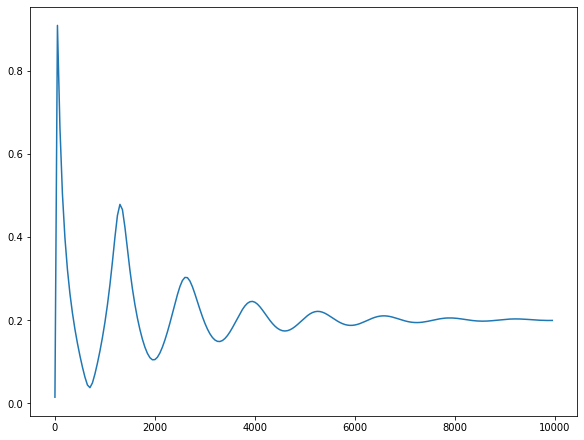

In [8]:
rows = 1
cols = 1
f1, ax1 = plt.subplots(rows, cols, figsize = (8, 6), constrained_layout=True)
ax1.plot(frequency_array, absorption_array)